## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

In [39]:
ycopy = y2015.copy()   #Save for later mistakes

In [40]:
y2015.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)

In [41]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [42]:
y2015.info()

#We may need to drop the object features, unless they can be converted to useful numericals

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(85), object(26)
memory usage: 356.6+ MB


In [126]:
y2015 = ycopy.copy()

## Initial Visualization of Target Feature

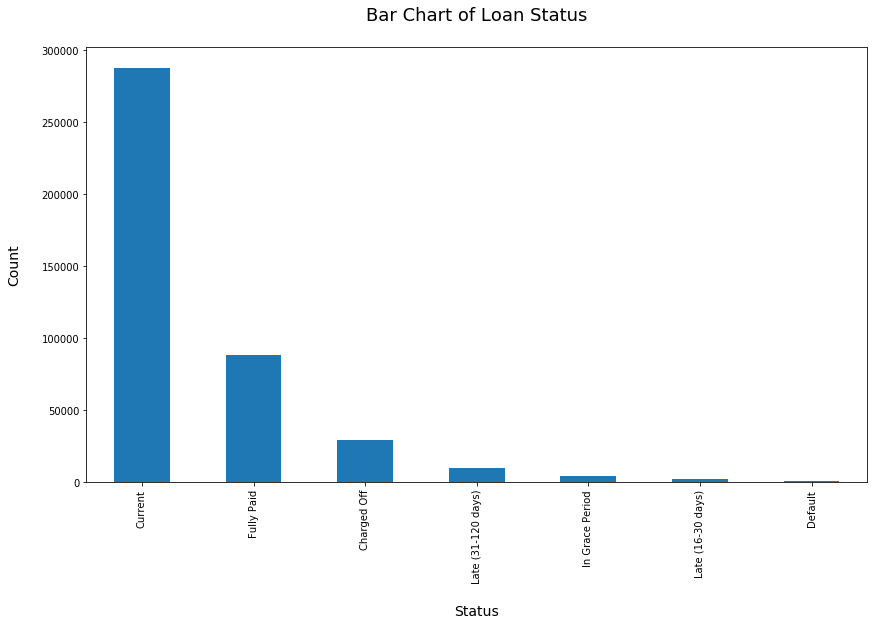

In [162]:
ax = y2015['loan_status'].value_counts().plot(kind='bar', figsize=(14,8), fontsize = 10)
ax.set_title("Bar Chart of Loan Status\n", fontsize=18)
ax.set_xlabel("\nStatus", fontsize=14)
ax.set_ylabel("Count\n", fontsize=14)
plt.show()

## Data Cleaning and Feature Reduction

In [105]:
#We have way too many columns to reasonably work with. Let's drop a lot of them

#Percentage of remaining missing values per category:
(y2015.isnull().sum()/y2015.isnull().count()).sort_values()

id                                0.000000
delinq_amnt                       0.000005
chargeoff_within_12_mths          0.000005
avg_cur_bal                       0.000005
acc_open_past_24mths              0.000005
total_rev_hi_lim                  0.000005
tot_cur_bal                       0.000005
tot_coll_amt                      0.000005
mo_sin_old_rev_tl_op              0.000005
acc_now_delinq                    0.000005
application_type                  0.000005
policy_code                       0.000005
collections_12_mths_ex_med        0.000005
last_pymnt_amnt                   0.000005
collection_recovery_fee           0.000005
recoveries                        0.000005
total_rec_late_fee                0.000005
total_bc_limit                    0.000005
mo_sin_rcnt_rev_tl_op             0.000005
mo_sin_rcnt_tl                    0.000005
mort_acc                          0.000005
total_bal_ex_mort                 0.000005
tot_hi_cred_lim                   0.000005
tax_liens  

In [204]:
y2015 = ycopy.copy()

In [205]:
#Drop id and member_id columns, as they aren't useful for our analysis
y2015 = y2015.drop(['id','member_id'], axis=1)

#Drop rows containing all NaNs
y2015 = y2015.dropna(how='all')
y2015 = y2015.reset_index(drop=True)

In [206]:
#Drop columns that contain any NaNs (we have enough features that our model should be unaffected)
#Also drop any columns that only contain 1 value, because that isn't useful
null_props = (y2015.isnull().sum()/y2015.isnull().count())
mins = y2015.describe().loc['min']
maxes = y2015.describe().loc['max']

drop_list = []
for col in null_props.index:
    if null_props[col] > 0:
        drop_list.append(col)
    elif col in mins.index:
        if mins[col] == maxes[col]:
            drop_list.append(col)

drop_list

['emp_title',
 'emp_length',
 'desc',
 'title',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'revol_util',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'mths_since_last_major_derog',
 'policy_code',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_il_6m',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_rev_accts',
 'num_tl_120dpd_2m',
 'percent_bc_gt_75']

In [207]:
y2015 = y2015.drop(drop_list, axis=1)

#Double-check: Percentage of remaining missing values per category:
(y2015.isnull().sum()/y2015.isnull().count()).sort_values()

loan_amnt                     0.0
collections_12_mths_ex_med    0.0
application_type              0.0
acc_now_delinq                0.0
tot_coll_amt                  0.0
tot_cur_bal                   0.0
total_rev_hi_lim              0.0
acc_open_past_24mths          0.0
avg_cur_bal                   0.0
chargeoff_within_12_mths      0.0
delinq_amnt                   0.0
mo_sin_old_rev_tl_op          0.0
mo_sin_rcnt_rev_tl_op         0.0
mo_sin_rcnt_tl                0.0
mort_acc                      0.0
num_accts_ever_120_pd         0.0
num_actv_bc_tl                0.0
num_actv_rev_tl               0.0
total_bal_ex_mort             0.0
tot_hi_cred_lim               0.0
tax_liens                     0.0
pub_rec_bankruptcies          0.0
pct_tl_nvr_dlq                0.0
num_tl_op_past_12m            0.0
last_pymnt_amnt               0.0
num_tl_90g_dpd_24m            0.0
num_sats                      0.0
num_rev_tl_bal_gt_0           0.0
num_op_rev_tl                 0.0
num_il_tl     

In [117]:
#We've cleared out many non-useful features, but we still have 70, which is a lot to work with

#Object Columns: Are any useful?
y2015.describe(include=['O'])

,term,int_rate,grade,sub_grade,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,zip_code,addr_state,earliest_cr_line,initial_list_status,application_type
count,421095,421095,421095,421095,421095,421095,421095,421095,421095,421095,421095,421095,421095,421095,421095,421095
unique,2,110,7,35,4,3,12,7,1,421095,14,914,49,668,2,2
top,36 months,7.89%,C,C1,MORTGAGE,Source Verified,Oct-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,945xx,CA,Aug-2002,w,INDIVIDUAL
freq,283173,20307,120567,26434,207683,179565,48631,287414,421095,1,250020,4466,58067,3235,267252,420584


In [208]:
#Convert interest rate to numeric
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'))

#Create new feature: length of credit history
y2015['len_history'] = list(np.array([2015]*len(y2015['earliest_cr_line'])) - np.array([float(x[1]) for x in y2015['earliest_cr_line'].str.split('-')]))

In [209]:
print('TARGET VARIABLE - Loan Status: ', np.unique(y2015['loan_status']))
print('\n')

print('Term Types: ', np.unique(y2015['term']))
print('Home Ownership Types: ', np.unique(y2015['home_ownership']))
print('Application Types: ', np.unique(y2015['application_type']))
print('Verification Statuses: ', np.unique(y2015['verification_status']))

TARGET VARIABLE - Loan Status:  ['Charged Off' 'Current' 'Default' 'Fully Paid' 'In Grace Period'
 'Late (16-30 days)' 'Late (31-120 days)']


Term Types:  [' 36 months' ' 60 months']
Home Ownership Types:  ['ANY' 'MORTGAGE' 'OWN' 'RENT']
Application Types:  ['INDIVIDUAL' 'JOINT']
Verification Statuses:  ['Not Verified' 'Source Verified' 'Verified']


## Convert String Categoricals to Dummy

In [212]:
for col in ['loan_status', 'term', 'home_ownership', 'application_type', 'verification_status']:
    unique_var = list(np.unique(y2015[col]))
    #Convert string categorical variables to numerical dummies
    dummy_var = []
    for row in y2015[col]:
        for i in range(len(unique_var)):
            if row == unique_var[i]:
                dummy_var.append(i)

    y2015['Dummy ' + col] = dummy_var

In [230]:
#Drop all string categoricals (except our target variable)
str_cat = list(y2015.describe(include=['O']).columns.drop('loan_status'))
y2015 = y2015.drop(str_cat, axis=1)

## Remove Outliers from Numeric Variables (via Winsorization)

### Extent of Outliers (Tukey's Method)

In [251]:
import math

#Determine parameters of outlier removal using Tukey's method
outlier_loc = []
top_outlier_percent = []
bottom_outlier_percent = []

for col in list(y2015.columns.drop(['loan_status', 'Dummy loan_status', 'Dummy term', 'Dummy home_ownership', 'Dummy application_type', 'Dummy verification_status'])):
    q75, q25 = np.percentile(y2015[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    if (len((np.where(y2015[col] > max_val))[0]) > 0):
        if (len((np.where(y2015[col] < min_val))[0]) > 0):
            loc_now = 'both ends'
        else:
            loc_now = 'top'
    else:
        loc_now = 'bottom'
    
    outlier_loc.append(loc_now)
    print("Percentage of outliers in {}, located at {} of range: {}".format(col, loc_now, len((np.where((y2015[col] > max_val) |(y2015[col] < min_val))[0]))/len(y2015)))
    
    top_percent = len((np.where((y2015[col] > max_val))[0]))/len(y2015)
    #Get values to the closest whole percent
    top_outlier_percent.append(math.ceil(top_percent*100)/100)
    
    bottom_percent = len((np.where((y2015[col] < min_val))[0]))/len(y2015)
    #Get values to the closest whole percent
    bottom_outlier_percent.append(math.ceil(bottom_percent*100)/100)

Percentage of outliers in loan_amnt, located at bottom of range: 0.0
Percentage of outliers in funded_amnt, located at bottom of range: 0.0
Percentage of outliers in funded_amnt_inv, located at bottom of range: 0.0
Percentage of outliers in int_rate, located at top of range: 0.007710849095809734
Percentage of outliers in installment, located at top of range: 0.027062776808083687
Percentage of outliers in annual_inc, located at top of range: 0.04511808499269761
Percentage of outliers in dti, located at top of range: 0.00015198470653890453
Percentage of outliers in delinq_2yrs, located at top of range: 0.20681081466177467
Percentage of outliers in inq_last_6mths, located at top of range: 0.04048730096534036
Percentage of outliers in open_acc, located at top of range: 0.025761407758344318
Percentage of outliers in pub_rec, located at top of range: 0.17671784276707156
Percentage of outliers in revol_bal, located at top of range: 0.05979885773993992
Percentage of outliers in total_acc, loca

In [241]:
y_f = y2015.copy()

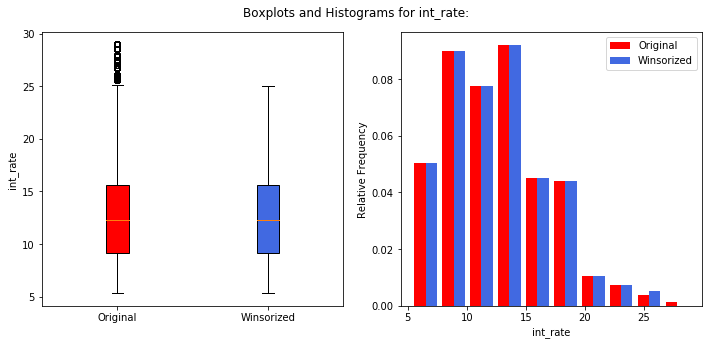

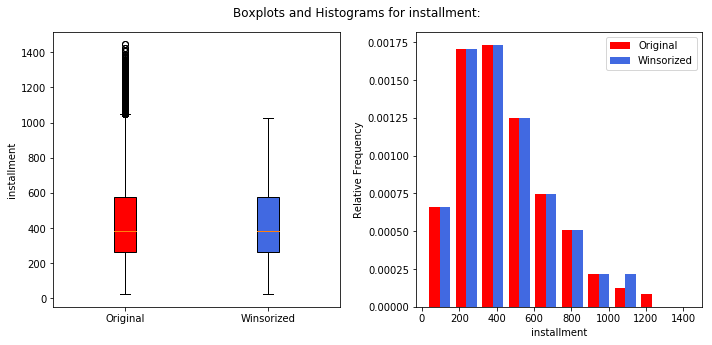

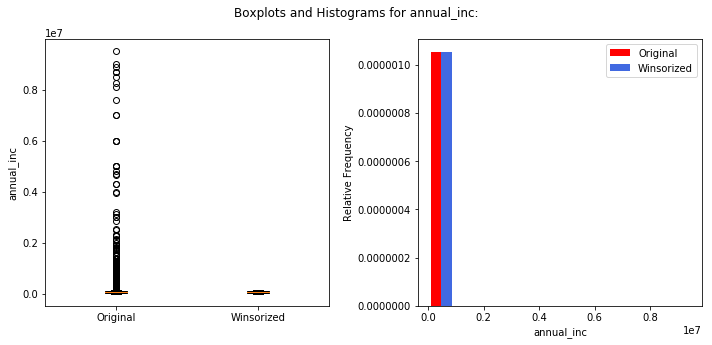

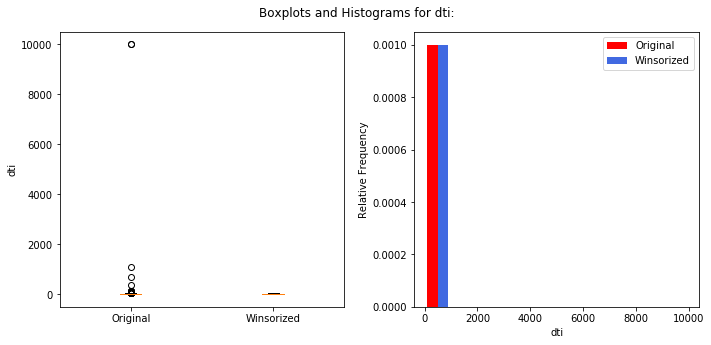

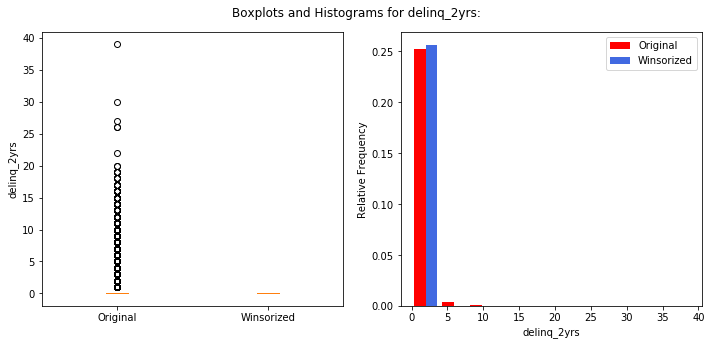

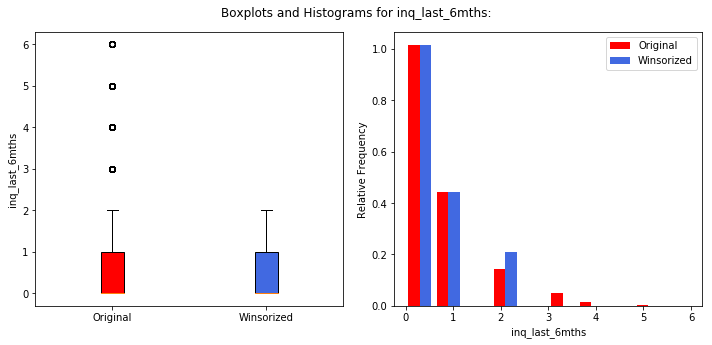

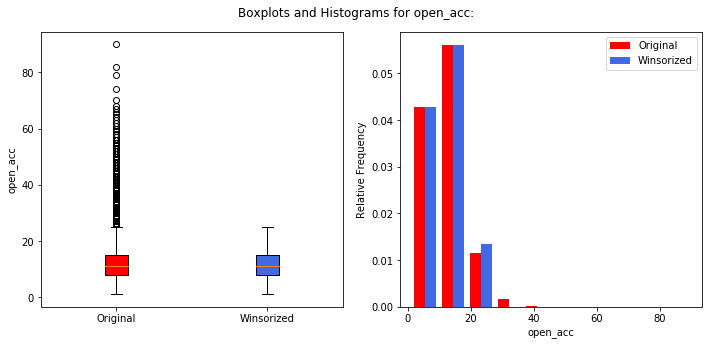

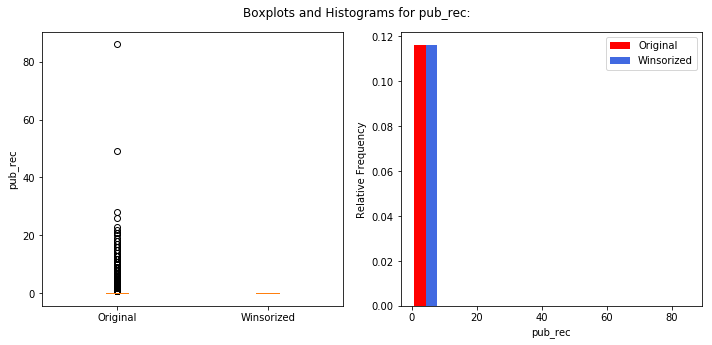

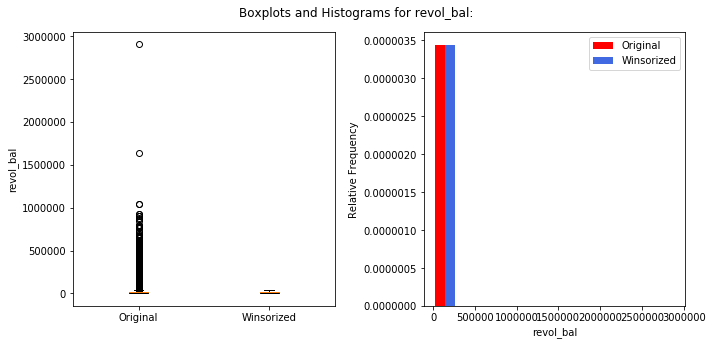

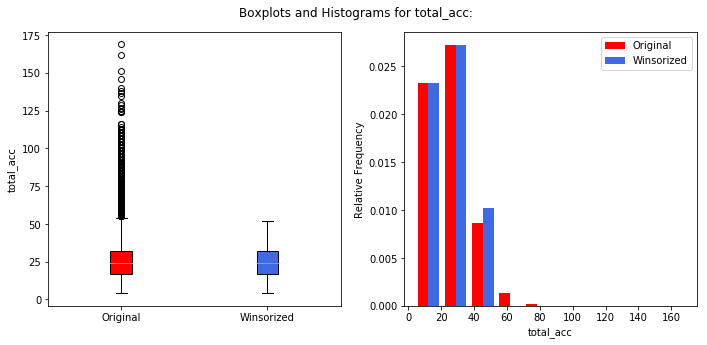

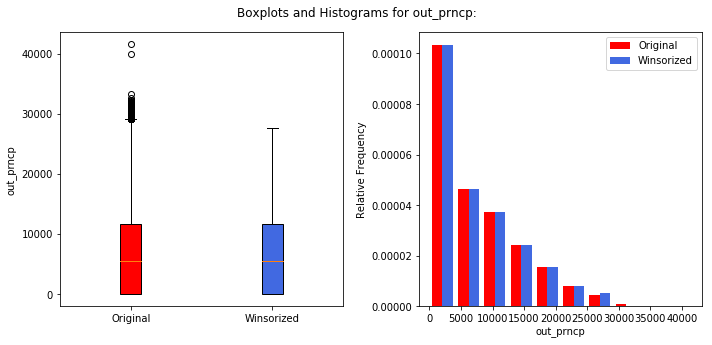

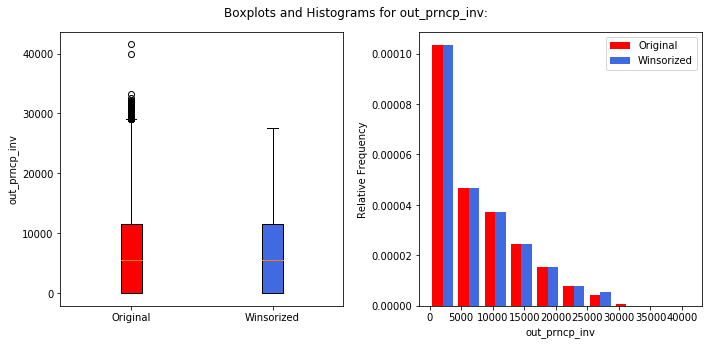

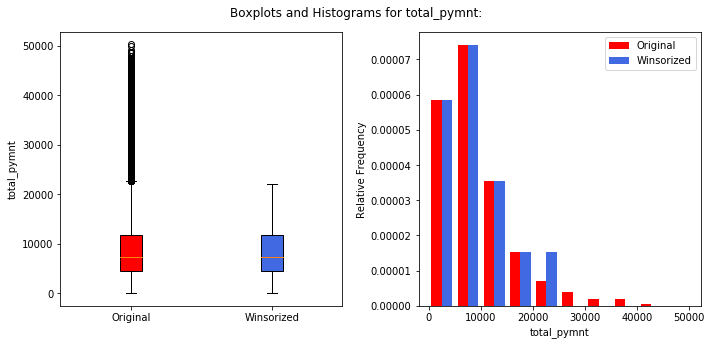

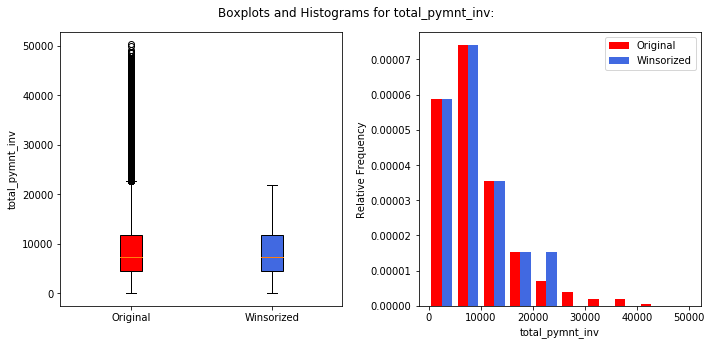

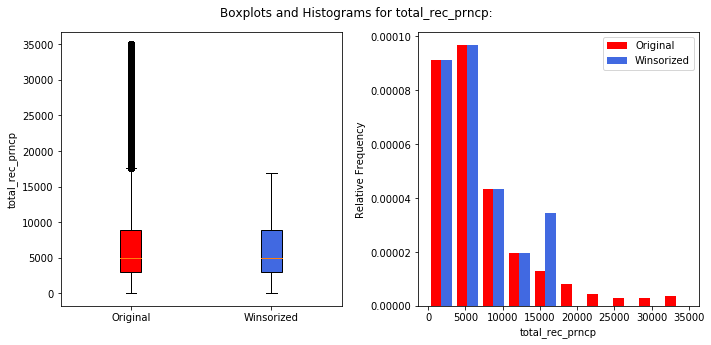

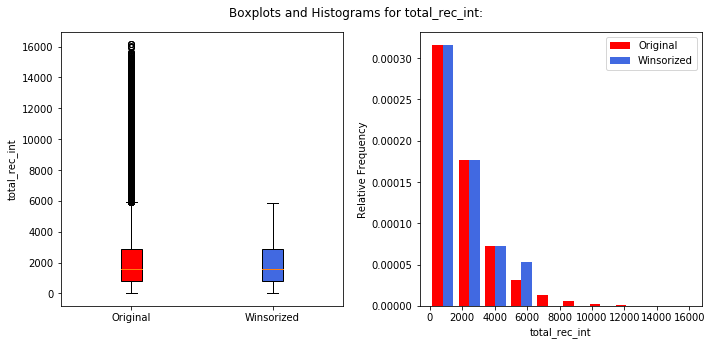

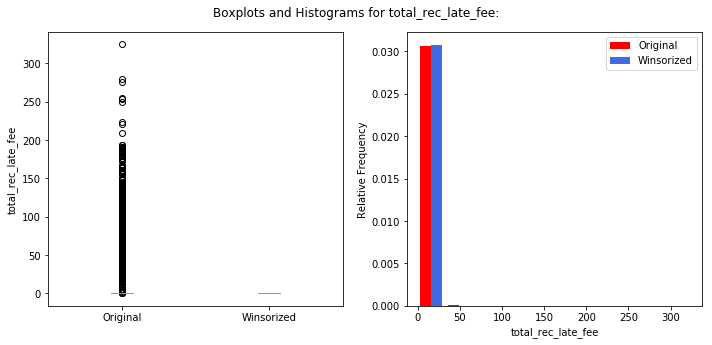

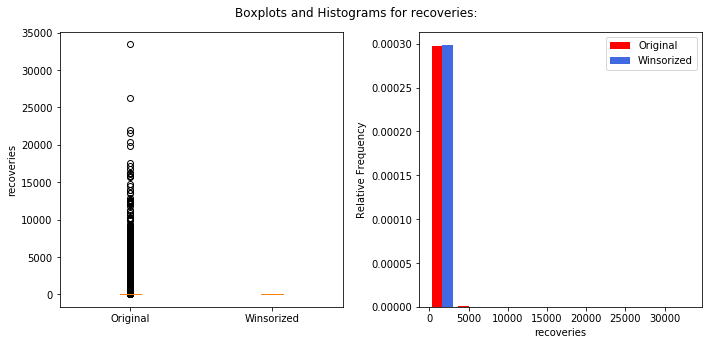

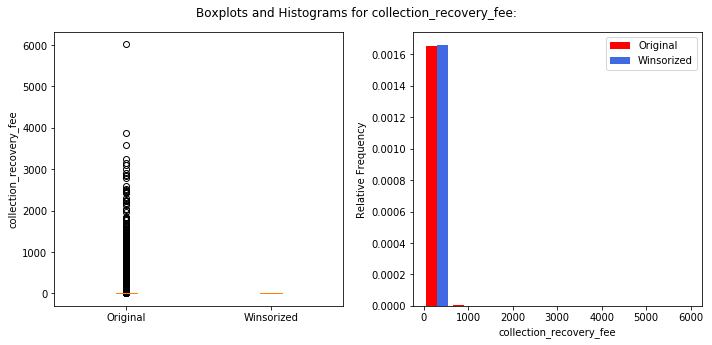

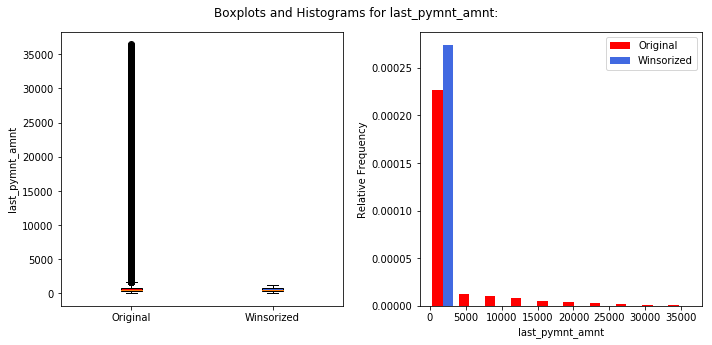

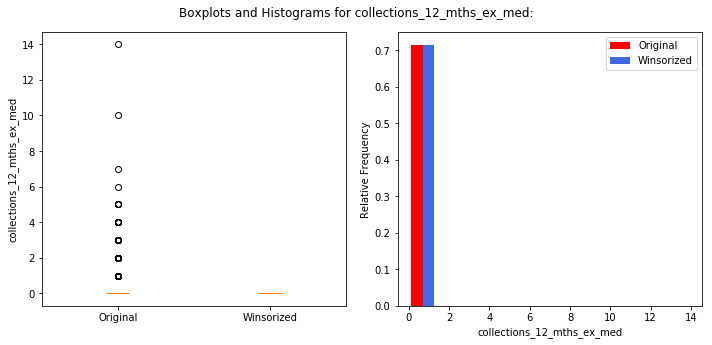

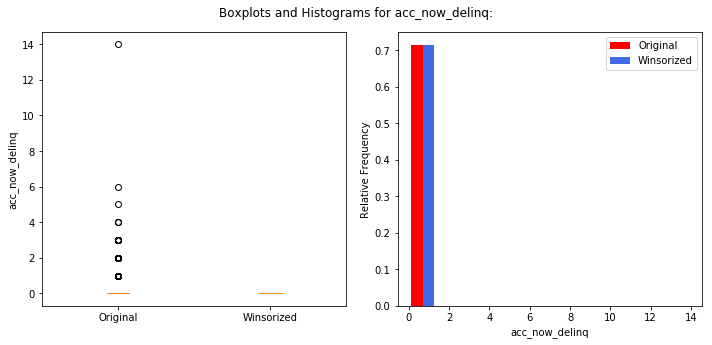

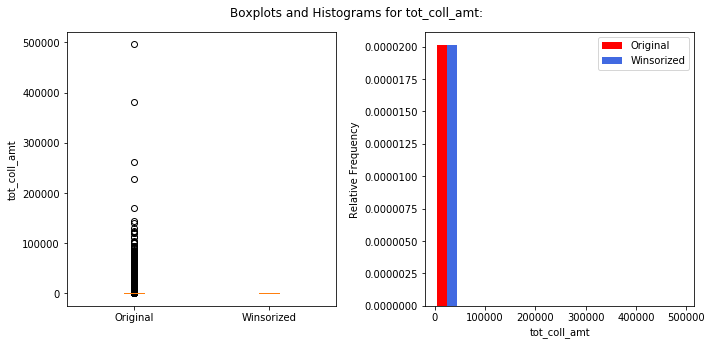

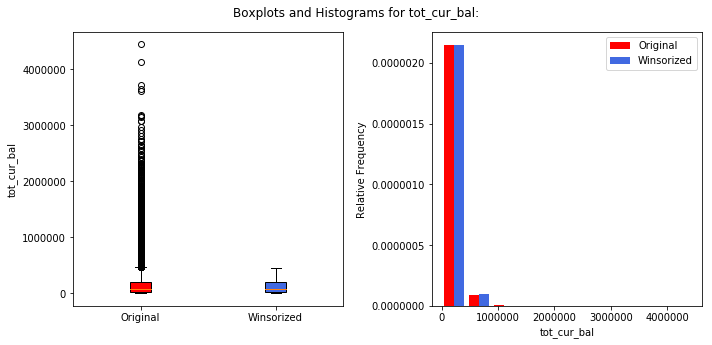

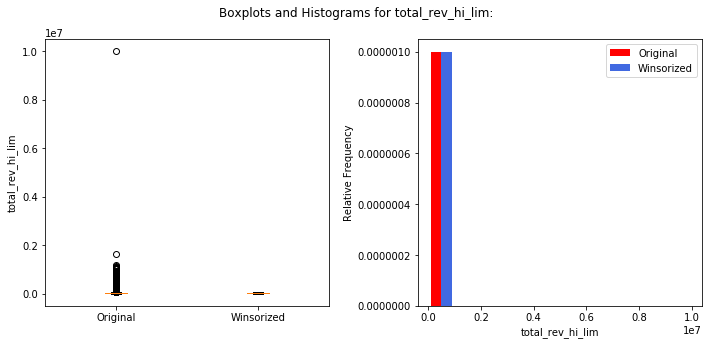

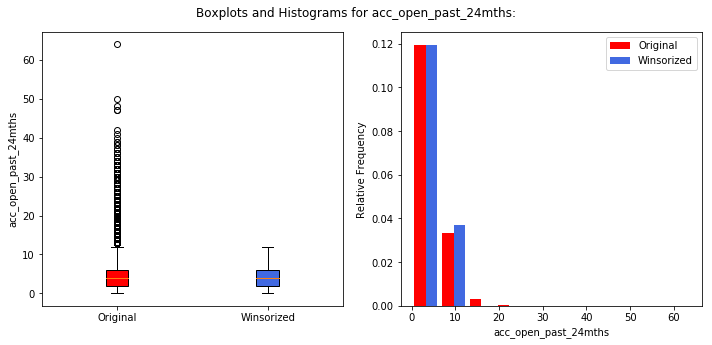

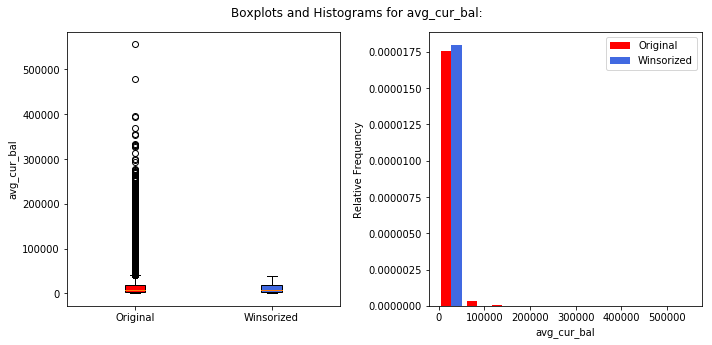

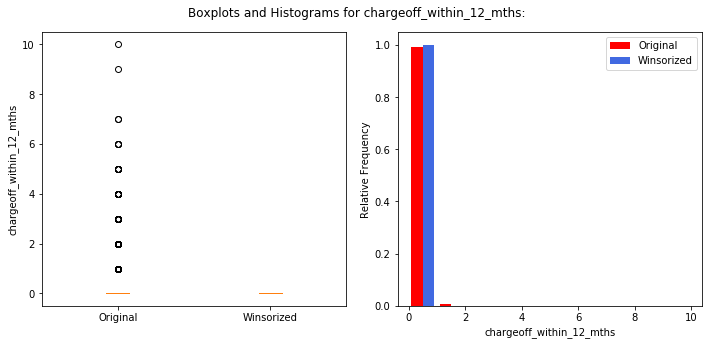

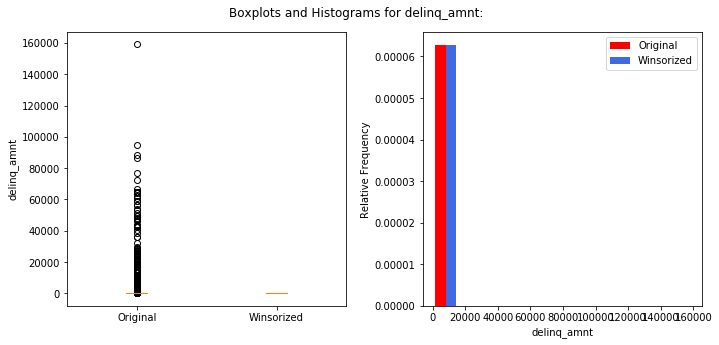

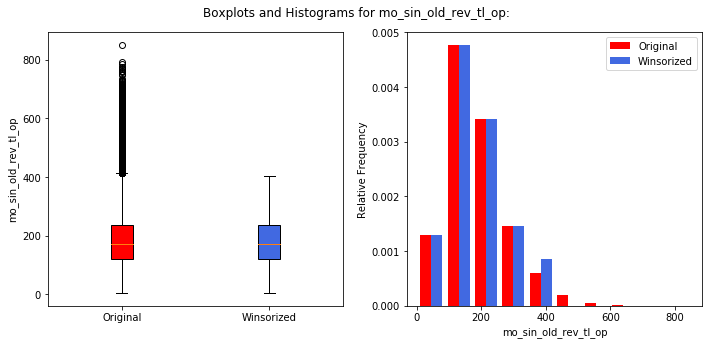

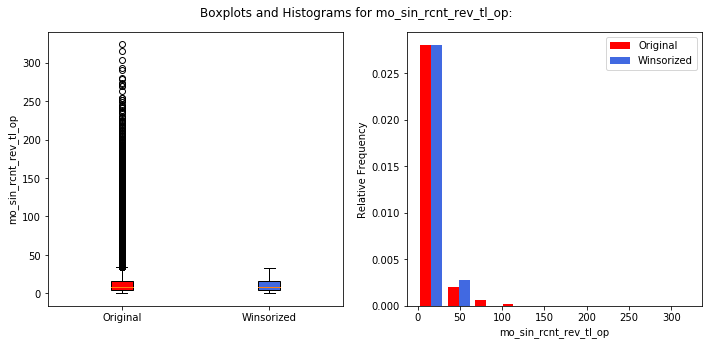

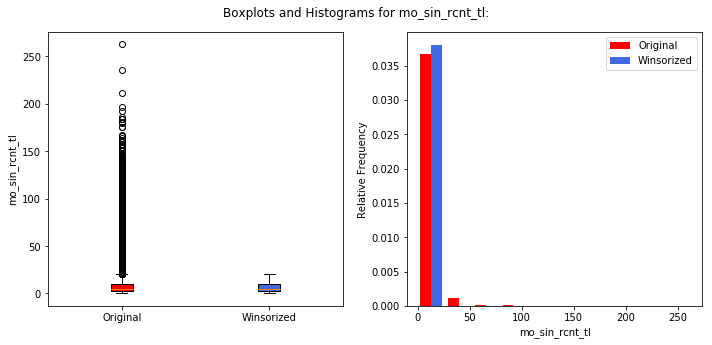

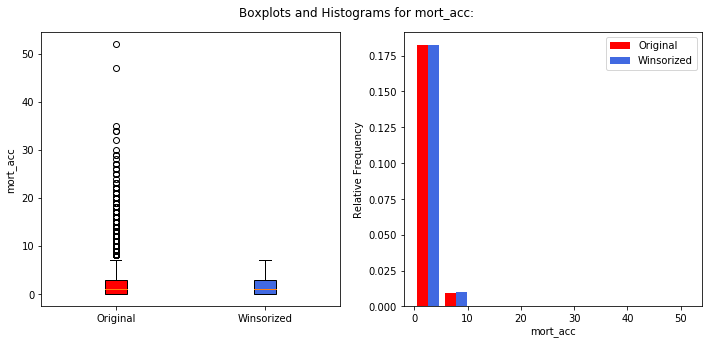

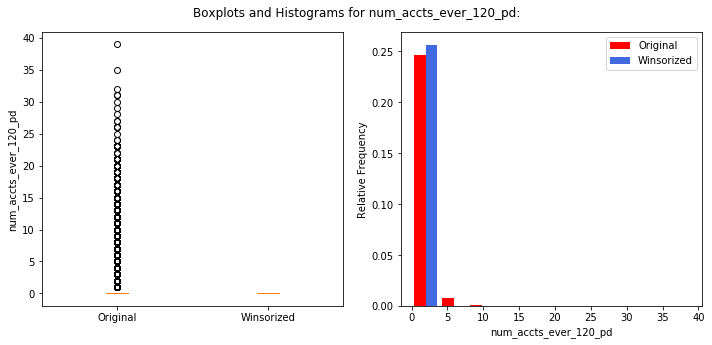

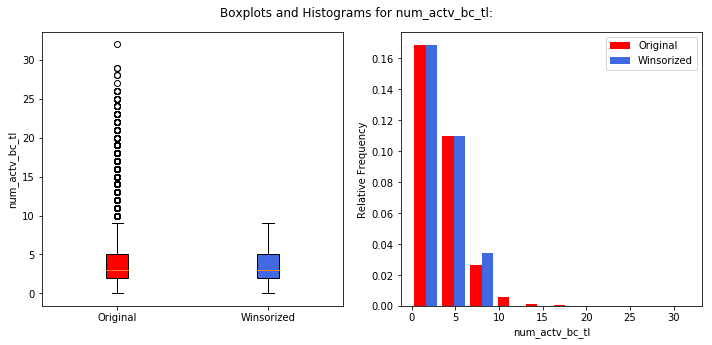

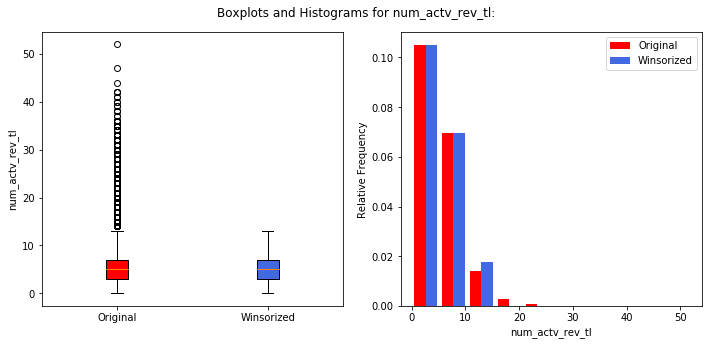

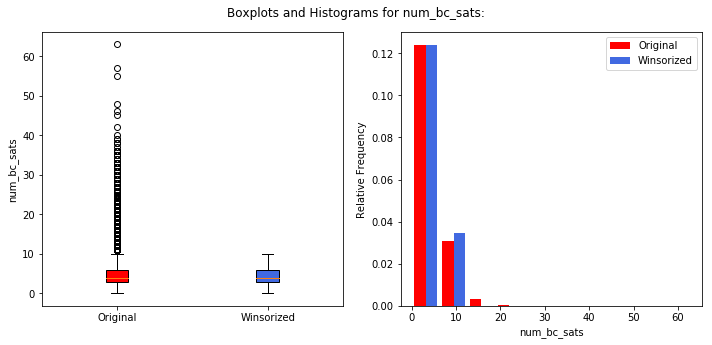

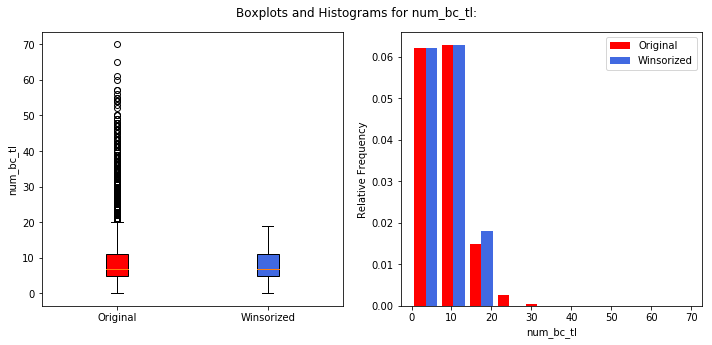

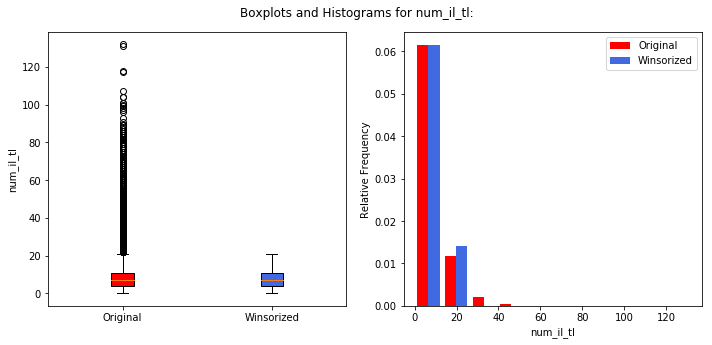

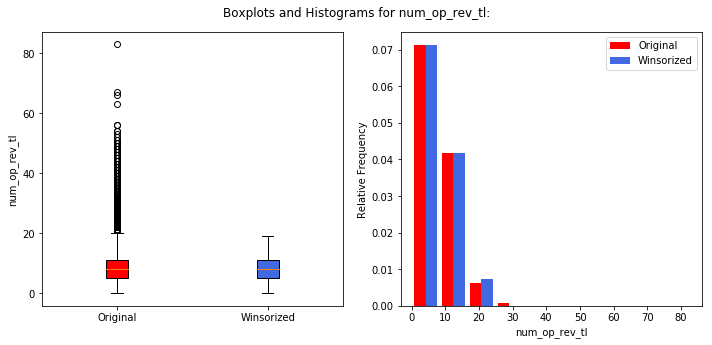

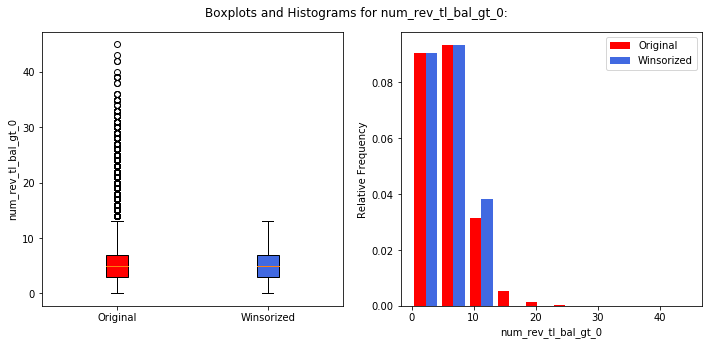

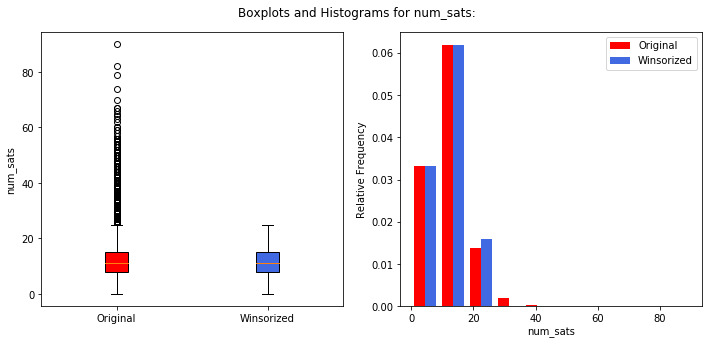

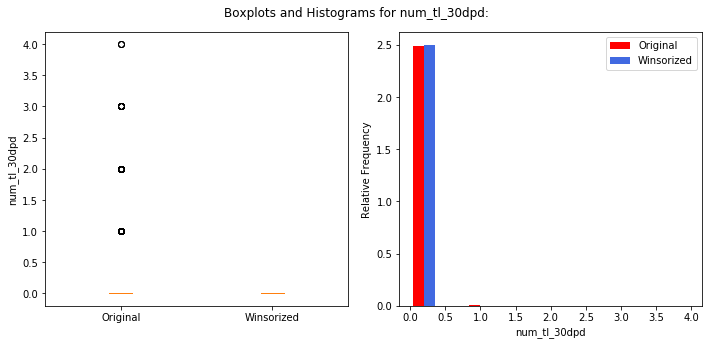

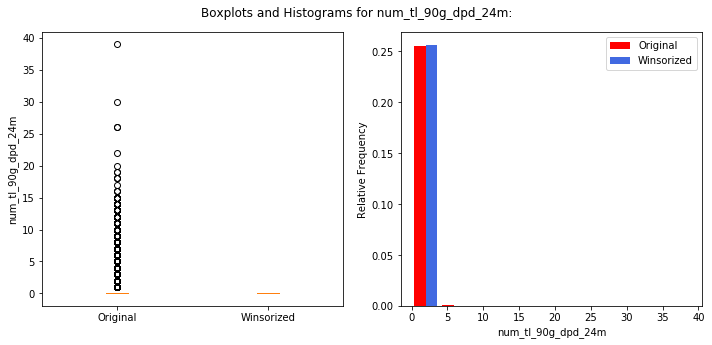

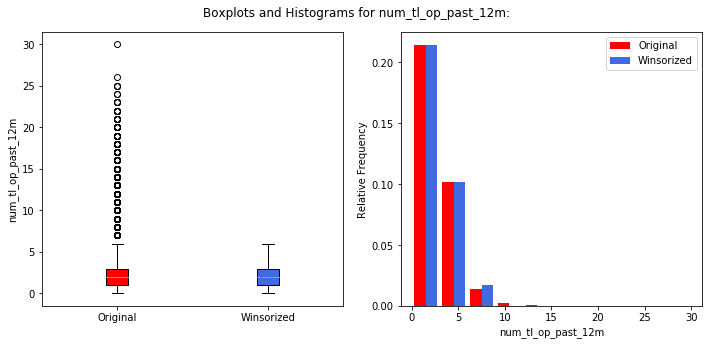

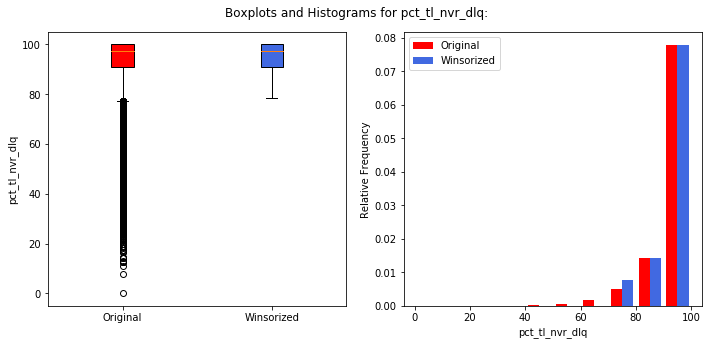

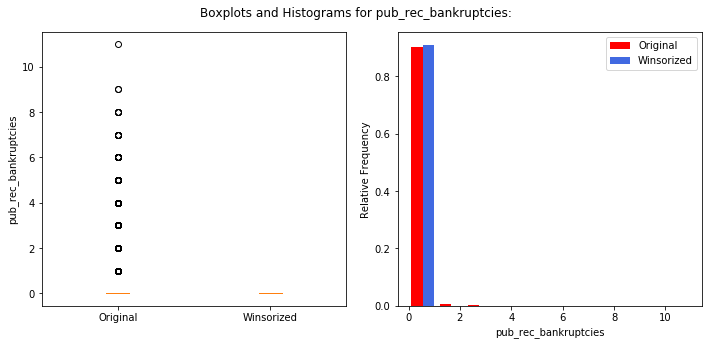

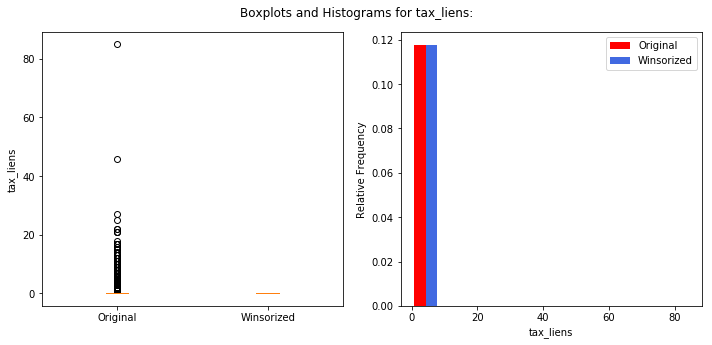

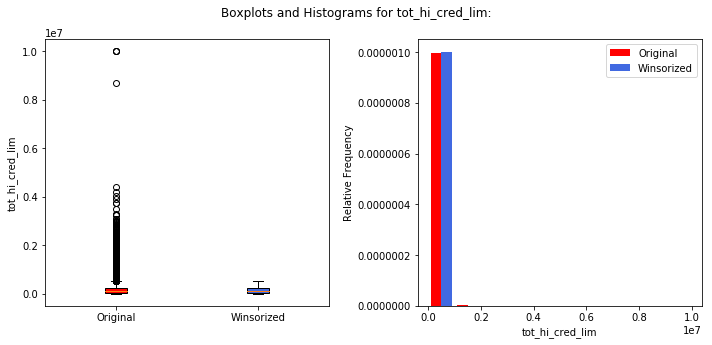

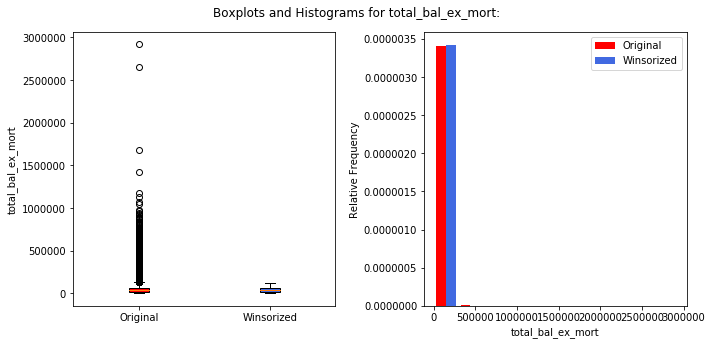

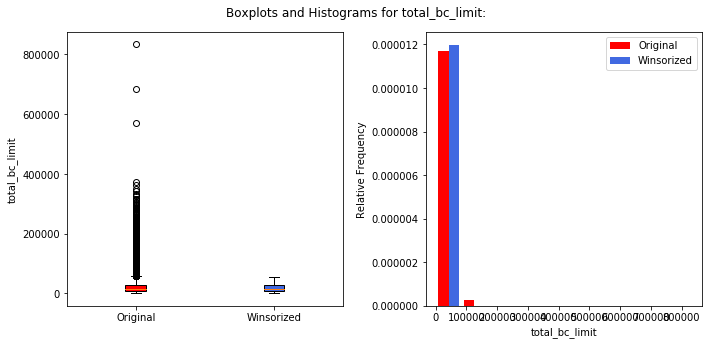

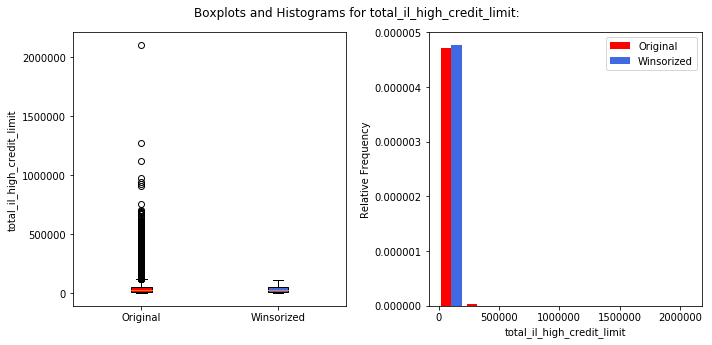

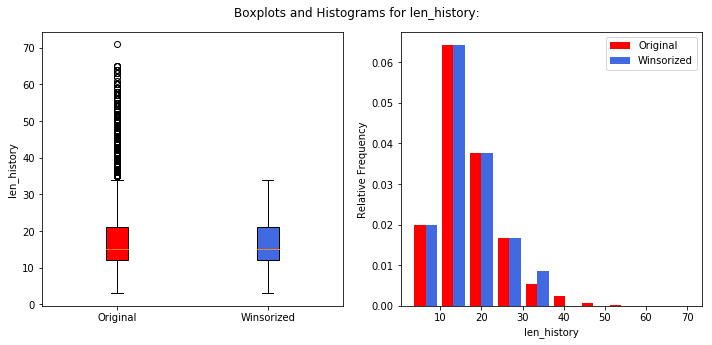

In [326]:
#Transform/remove the outliers, using winsorize()
from scipy.stats.mstats import winsorize

winsorized_cols = pd.DataFrame()

cols = y2015.columns.drop(['loan_status', 'Dummy loan_status', 'Dummy term', 'Dummy home_ownership', 'Dummy application_type', 'Dummy verification_status'])
for i in range(len(cols)):
    winsorized_cols[cols[i]] = winsorize(y2015[cols[i]], (bottom_outlier_percent[i], top_outlier_percent[i]))

for j in ['loan_status', 'Dummy loan_status', 'Dummy term', 'Dummy home_ownership', 'Dummy application_type', 'Dummy verification_status']:
    winsorized_cols[j] = y2015[j]

#Analyze the effects of winsorization on boxplots/histograms:
i=0
for col in cols:
    if (top_outlier_percent[i]>0 or bottom_outlier_percent[i]>0):
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        box = plt.boxplot([y2015[col], winsorized_cols[col]], patch_artist = True, labels = ['Original', 'Winsorized'])
        plt.ylabel(col)

        colors = ['red', 'royalblue']
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        plt.subplot(1,2,2)
        plt.hist([y2015[col], winsorized_cols[col]], color=colors, label = ['Original', 'Winsorized'], normed=True)
        plt.xlabel(col)
        plt.ylabel('Relative Frequency')
        plt.legend()

        plt.suptitle('Boxplots and Histograms for ' + col + ':')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    i = i + 1

y2015 = winsorized_cols.copy()

In [ ]:
delinq_2yrs                        NaN
pub_rec                            NaN
total_rec_late_fee                 NaN
recoveries                         NaN
collection_recovery_fee            NaN
collections_12_mths_ex_med         NaN
acc_now_delinq                     NaN
tot_coll_amt                       NaN
chargeoff_within_12_mths           NaN
delinq_amnt                        NaN
num_accts_ever_120_pd              NaN
num_tl_30dpd                       NaN
num_tl_90g_dpd_24m                 NaN
pub_rec_bankruptcies               NaN
tax_liens                          NaN

## Correlations Between Winsorized Features and Target

In [327]:
abs(y2015.corr()['Dummy loan_status']).sort_values(ascending=False)[:10]

Dummy loan_status       1.000000
last_pymnt_amnt         0.501858
total_rec_prncp         0.410015
total_pymnt             0.335875
total_pymnt_inv         0.335846
out_prncp_inv           0.219999
out_prncp               0.219969
total_rec_int           0.082143
acc_open_past_24mths    0.069309
num_tl_op_past_12m      0.066454
Name: Dummy loan_status, dtype: float64

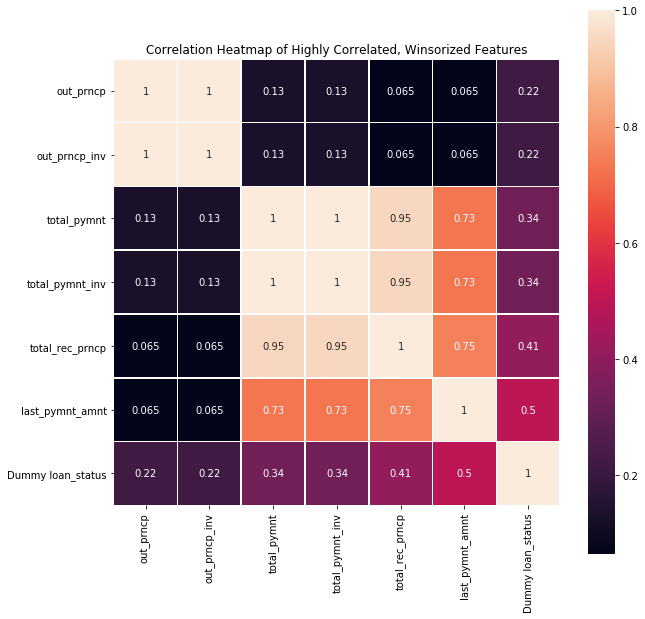

In [328]:
#Plot correlation matrix of features with at least 10% correlation to loan_status
plt.figure(figsize=(10,10))
pp_cols = list(y2015.corr().columns[list(np.where(abs(y2015.corr()['Dummy loan_status'])>0.1)[0])])

sns.heatmap(abs(y2015[pp_cols].corr()), square=True, linewidths=.5, annot=True)
plt.title('Correlation Heatmap of Highly Correlated, Winsorized Features')
plt.show()

## Drop Extraneous Highly Correlated Features

In [329]:
drop_features = []
corrs = y2015.corr()
headers = []
for col in list(corrs.columns):
    headers.append(col)
    for row in list(corrs.columns.drop(headers)):
        if col != row:
            if abs(corrs[col][row])>0.8:
                if (col!='Dummy loan_status' and row!='Dummy loan_status'):
                    if (abs(corrs['Dummy loan_status'][col])>abs(corrs['Dummy loan_status'][row])):
                        drop_features.append(col)
                    elif (abs(corrs['Dummy loan_status'][col])<abs(corrs['Dummy loan_status'][row])):
                        drop_features.append(row)

drop_features = list(np.unique(drop_features))

In [330]:
y2015 = y2015.drop(drop_features, axis=1)

In [331]:
y2 = y2015.copy()

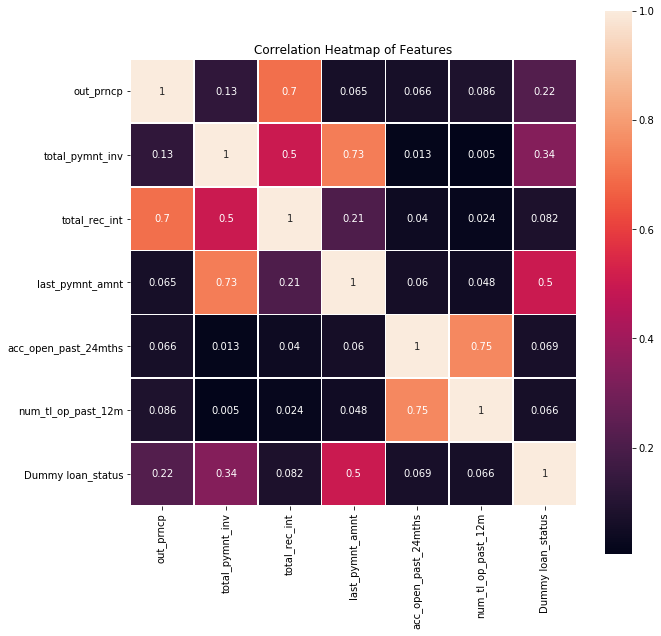

In [332]:
#Plot new correlation matrix of features
plt.figure(figsize=(10,10))
pp_cols = list(y2015.corr().columns[list(np.where(abs(y2015.corr()['Dummy loan_status'])>0.05)[0])])

sns.heatmap(abs(y2015[pp_cols].corr()), square=True, linewidths=.5, annot=True)
plt.title('Correlation Heatmap of Features')
plt.show()

## Remove NaN Correlations

In [335]:
abs(y2015.corr()['Dummy loan_status']).sort_values(ascending=False)

Dummy loan_status             1.000000
last_pymnt_amnt               0.501858
total_pymnt_inv               0.335846
out_prncp                     0.219969
total_rec_int                 0.082143
acc_open_past_24mths          0.069309
num_tl_op_past_12m            0.066454
mo_sin_rcnt_tl                0.047239
Dummy term                    0.043518
dti                           0.041040
total_acc                     0.039164
revol_bal                     0.037452
mo_sin_rcnt_rev_tl_op         0.035798
inq_last_6mths                0.034194
num_il_tl                     0.029744
mort_acc                      0.028474
int_rate                      0.028447
tot_hi_cred_lim               0.020965
len_history                   0.020687
num_bc_tl                     0.020581
annual_inc                    0.020037
Dummy home_ownership          0.016809
total_rev_hi_lim              0.011611
Dummy verification_status     0.011542
num_bc_sats                   0.006827
pct_tl_nvr_dlq           

In [340]:
drop = list(abs(y2015.corr()['Dummy loan_status'])[abs(y2015.corr()['Dummy loan_status']).isnull()].index)
y2015 = y2015.drop(drop, axis=1)

In [341]:
#What do we have left?
y2015.columns

Index(['int_rate', 'installment', 'annual_inc', 'dti', 'inq_last_6mths',
       'revol_bal', 'total_acc', 'out_prncp', 'total_pymnt_inv',
       'total_rec_int', 'last_pymnt_amnt', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'len_history', 'loan_status', 'Dummy loan_status',
       'Dummy term', 'Dummy home_ownership', 'Dummy application_type',
       'Dummy verification_status'],
      dtype='object')

In [345]:
y2015.shape
#We have our dataset down to 31 features, from an original 111. 

(421095, 31)

## Model Test #1

In [344]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop(['loan_status', 'Dummy loan_status'], 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.957802  , 0.96191019, 0.96020042, 0.9596305 , 0.95927333,
       0.95920209, 0.95910613, 0.95896364, 0.95910419, 0.95860447])

## Model Test #2

In [346]:
y3 = y2015.copy()

In [350]:
#Drop all columns with correlation less than 5%
drops = list(y2015.corr().columns[list(np.where(abs(y2015.corr()['Dummy loan_status'])<0.05)[0])])
y2015 = y2015.drop(drops, axis=1)

In [351]:
rfc = ensemble.RandomForestClassifier()
X = y2015.drop(['loan_status', 'Dummy loan_status'], 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.89437439, 0.96570967, 0.96112655, 0.95694712, 0.95476134,
       0.95393018, 0.95385785, 0.95544895, 0.9564443 , 0.9570845 ])

## Model Test #3

In [354]:
y4 = y2015.copy()

In [355]:
#Drop all columns with correlation less than 10%
drops = list(y2015.corr().columns[list(np.where(abs(y2015.corr()['Dummy loan_status'])<0.1)[0])])
y2015 = y2015.drop(drops, axis=1)

In [356]:
rfc = ensemble.RandomForestClassifier()
X = y2015.drop(['loan_status', 'Dummy loan_status'], 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.79102847, 0.95359882, 0.93381777, 0.94756714, 0.94286393,
       0.93350748, 0.91018547, 0.92505165, 0.93704135, 0.9516221 ])

In [358]:
#Final data
print(y2015.shape)
y2015.columns

(421095, 5)


Index(['out_prncp', 'total_pymnt_inv', 'last_pymnt_amnt', 'loan_status',
       'Dummy loan_status'],
      dtype='object')

After removing outliers, I was able to reduce the dataset to contain only 5 features (one of which is a dummy of the other, so really 4 features). This final version of the dataset, using a Random Forest Classifier, scores well above 90% on average when a 10-fold cross-validation is performed. However, one of the validations gives a value of ~80%, which may be something to be concerned about.